In [29]:
import pandas as pd

import os

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import glob


import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import json

In [30]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

a = config['retrained_color_palette']

In [31]:
# Retrieve patient names and loop through them
patient_list = [f"TNBC{i}" for i in range(1, 97)]

patients_to_remove = []
for patient in patient_list:
    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)

        for name in names:
            # print(opti_clusters.loc[name, 'n_clusters'])
            file = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            if os.path.exists(file) == False:
                patients_to_remove.append(patient)
                print(f"Removed patient {patient} as {file} does not exist")

# remove all patients in patients_to_remove from patient_list
patients_to_remove_set = set(patients_to_remove)
original_len = len(patient_list)
patient_list = [p for p in patient_list if p not in patients_to_remove_set]
print(f"Removed {original_len - len(patient_list)} patients; remaining {len(patient_list)} patients.")

Removed patient TNBC10 as ../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni/quantized_wasserstein_distance_molecular_combat_corrected_uni_5_clusters_patient_TNBC10.csv does not exist
Removed patient TNBC10 as ../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_4096_prototypes/quantized_wasserstein_distance_molecular_combat_corrected_uni_explora_kde_4096_prototypes_7_clusters_patient_TNBC10.csv does not exist
Removed patient TNBC10 as ../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_16384_prototypes/quantized_wasserstein_distance_molecular_combat_corrected_uni_explora_kde_16384_prototypes_6_clusters_patient_TNBC10.csv does not exist
Removed patient TNBC10 as ../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_65536_prototypes/quantized_wasserstein_distance_molecular_combat_corrected_uni_explora_kde_65536_prototyp

In [32]:
optimal_clusters = []
df_all_summary = []
for i_p, patient in enumerate(patient_list):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []

    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        


        for name in names:

            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            # filenames = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_*_clusters_patient_{patient}.csv"))
            # if len(filenames) == 0:
            #     print(f"No file found for {name}, {model_type}")
            # filename = filenames[0]
            print(filename)
            df = pd.read_csv(filename, index_col=0)


            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)

            if len(wasserstein_distances) == 0:
                mean_wasserstein_distance = np.nan
                std_wasserstein_distance = np.nan
                median_wasserstein_distance = np.nan
                min_wasserstein_distance = np.nan
                max_wasserstein_distance = np.nan
            else:
                mean_wasserstein_distance = np.mean(wasserstein_distances)
                std_wasserstein_distance = np.std(wasserstein_distances)
                median_wasserstein_distance = np.median(wasserstein_distances)

                min_wasserstein_distance = np.min(wasserstein_distances)
                max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params,
                                "patient": patient})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
stat = 'median'
# plt.figure(figsize=(8, 7))
# sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
# plt.xticks(rotation=90)
# sns.despine()

# plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw_filtered_normalized embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
# #plt.yscale("log")
# plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_raw_filtered_normalized_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()


../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni/quantized_wasserstein_distance_molecular_combat_corrected_uni_5_clusters_patient_TNBC1.csv
../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_4096_prototypes/quantized_wasserstein_distance_molecular_combat_corrected_uni_explora_kde_4096_prototypes_7_clusters_patient_TNBC1.csv
../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_16384_prototypes/quantized_wasserstein_distance_molecular_combat_corrected_uni_explora_kde_16384_prototypes_6_clusters_patient_TNBC1.csv
../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_kde_65536_prototypes/quantized_wasserstein_distance_molecular_combat_corrected_uni_explora_kde_65536_prototypes_4_clusters_patient_TNBC1.csv
../../results/TNBC/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni_explora_koleo_4096_prototypes/quan

In [33]:
import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

retrained_models = config['retrained_model_list1'] + config['retrained_model_list2']
sorted_retrained_models = sort_retrained_models(retrained_models)

print("Original order:", retrained_models)
print("Sorted order:", sorted_retrained_models)


palette = []
for model in sorted_retrained_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

Original order: ['uni', 'uni_explora_kde_4096_prototypes', 'uni_explora_kde_16384_prototypes', 'uni_explora_kde_65536_prototypes', 'uni_explora_koleo_4096_prototypes', 'uni_explora_koleo_16384_prototypes', 'uni_explora_koleo_65536_prototypes', 'uni', 'uni_full_kde_4096_prototypes', 'uni_full_kde_16384_prototypes', 'uni_full_kde_65536_prototypes', 'uni_full_koleo_4096_prototypes', 'uni_full_koleo_16384_prototypes', 'uni_full_koleo_65536_prototypes']
Sorted order: ['uni', 'uni_explora_kde_4096_prototypes', 'uni_explora_kde_16384_prototypes', 'uni_explora_kde_65536_prototypes', 'uni_full_kde_4096_prototypes', 'uni_full_kde_16384_prototypes', 'uni_full_kde_65536_prototypes', 'uni_explora_koleo_4096_prototypes', 'uni_explora_koleo_16384_prototypes', 'uni_explora_koleo_65536_prototypes', 'uni_full_koleo_4096_prototypes', 'uni_full_koleo_16384_prototypes', 'uni_full_koleo_65536_prototypes']


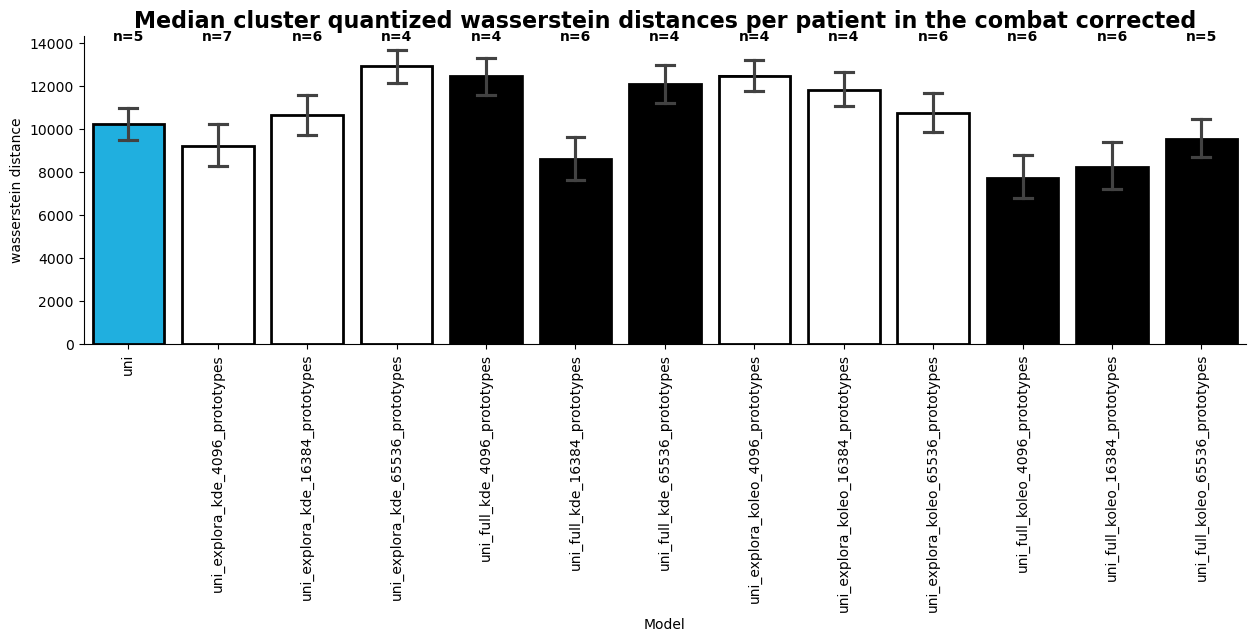

In [36]:
dfs = []
n_clusters = []
for model_type in sorted_retrained_models:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=palette, 
# palette=["deepskyblue", "white", "white", "white","black", 
#           "black", "black", "white", "white", "white", 
#         "black", "black", "black", ],
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the combat corrected", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=14000, s=f"n={int(n)}", ha='center', va='bottom', weight='bold')




plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_combat_corrected_normalized_embedding_per_patient.pdf"), bbox_inches='tight')

In [ ]:
df.loc[0]["wasserstein_distances"]

array([ 4675.34429932,  9288.1336263 ,  7159.6240595 , 10967.10620117,
        8672.25560784, 13711.50048828])

<Axes: xlabel='max_wasserstein_distance', ylabel='Density'>

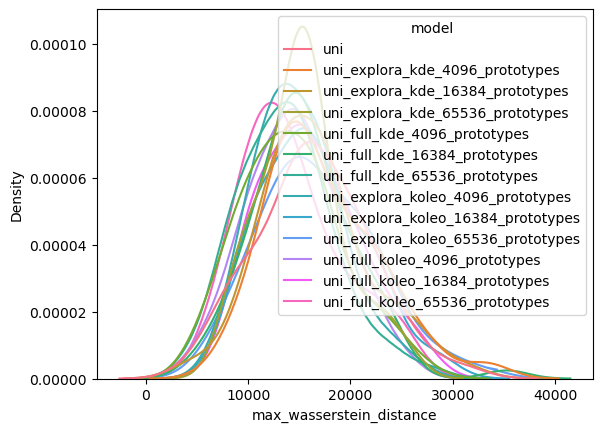

In [ ]:
sns.kdeplot(df, x="max_wasserstein_distance", hue="model",  common_norm=False)

In [ ]:
optimal_clusters = []
df_all_summary = []


for i_p, patient in enumerate(patient_list):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []


    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        
        


        for name in names:

            # print(f"model_type: {name}, optimal clusters: {opti_clusters.loc[name, 'n_clusters']}")

            
        # print(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv"))
            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            
            # print(filename)
            df = pd.read_csv(filename, index_col=0)

            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)

            if len(wasserstein_distances) == 0:
                mean_wasserstein_distance = np.nan
                std_wasserstein_distance = np.nan
                median_wasserstein_distance = np.nan
                min_wasserstein_distance = np.nan
                max_wasserstein_distance = np.nan
            else:
                mean_wasserstein_distance = np.mean(wasserstein_distances)
                std_wasserstein_distance = np.std(wasserstein_distances)
                median_wasserstein_distance = np.median(wasserstein_distances)

                min_wasserstein_distance = np.min(wasserstein_distances)
                max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
# stat = 'median'
# plt.figure(figsize=(8, 7))
# sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
# plt.xticks(rotation=90)
# sns.despine()

# plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the combat_corrected embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
# #plt.yscale("log")
# plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_combat_corrected_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()




FileNotFoundError: [Errno 2] No such file or directory: '../../results/TNBC/benchmark/uni_full_models/invasive_cancer_clustering/kmeans/uni_full_kde_4096_prototypes/quantized_wasserstein_distance_molecular_combat_corrected_uni_full_kde_4096_prototypes_6_clusters_patient_TNBC1.csv'

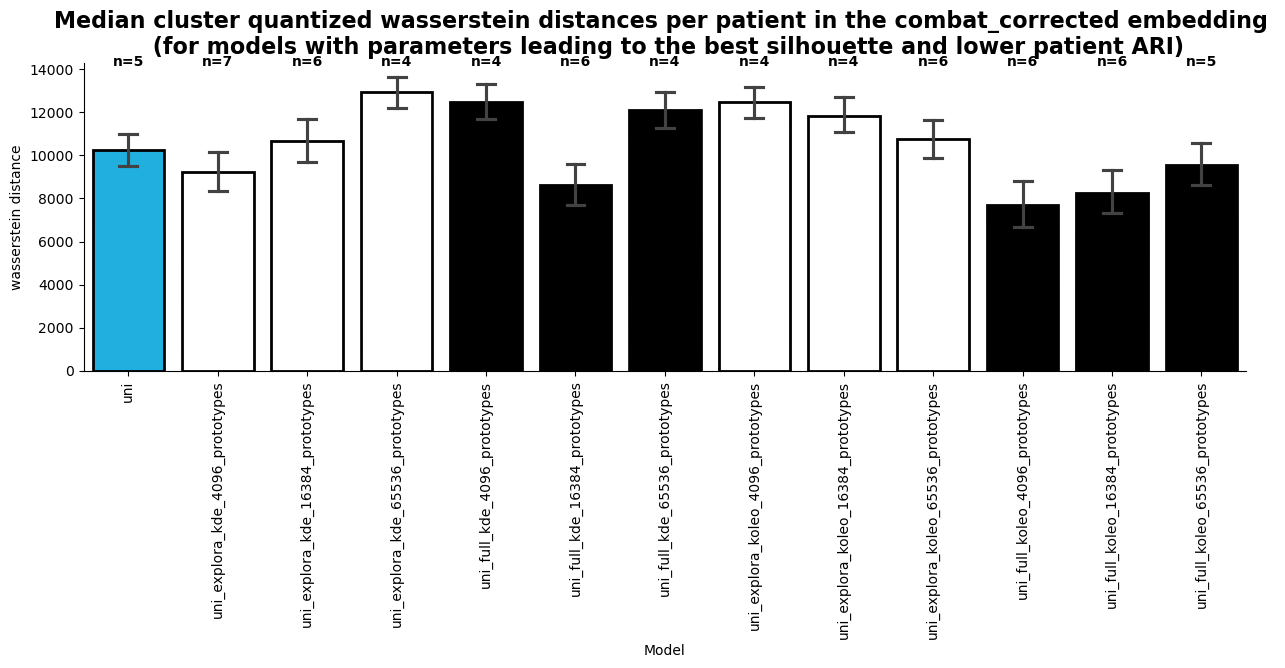

In [ ]:
dfs = []
n_clusters = []
for model_type in sorted_retrained_models:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=palette, 
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the combat corrected embedding", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=14000, s=f"n={n}", ha='center', va='bottom', weight='bold')



plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_combat_corrected_embedding_per_patient.pdf"), bbox_inches='tight')

In [18]:
df_summary = pd.DataFrame(columns=["n_clusters", 
                                   "wasserstein_distances", 
                                   "mean_wasserstein_distance", 
                                   "std_wasserstein_distance", 
                                   "median_wasserstein_distance", 
                                   "min_wasserstein_distance", 
                                   "max_wasserstein_distance",
                                   "model_type",
                                   "params"])
summary_list = []
all_names = []
wassersteins = []
optimal_clusters = pd.DataFrame()
for model_type, names, path in zip([config['retrained_model_list1_type'],
                             config['retrained_model_list2_type']],
                             [config['retrained_model_list1'],
                              config['retrained_model_list2']],
                              [config['retrained_benchmark_folder1'],
                               config['retrained_benchmark_folder2']]):
    
    path_to_invasive_cancer_clustering_results = os.path.join(path, "invasive_cancer_clustering", config['invasive_cancer_clustering_algo'])
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "optimal_clusters.csv"), index_col=0)
    dfs = []

    
    


    for name in names:
        # print(os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv"))
        # filename = os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_molecular_combat_corrected_5_clusters.csv")
        filename = os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_molecular_combat_corrected_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv")
        # filename = filenames[0]
        
        df = pd.read_csv(filename, index_col=0)

        n = opti_clusters.loc[name, 'n_clusters']
        optimal_clusters.loc[name, 'n_clusters'] = n

        n_clusters = df.shape[0]      
        # Get the lower triangular part of the matrix without the diagonal values
        lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
        wasserstein_distances = lower_matrix.stack().values
        wassersteins.append(wasserstein_distances)


        mean_wasserstein_distance = np.mean(wasserstein_distances)
        std_wasserstein_distance = np.std(wasserstein_distances)
        median_wasserstein_distance = np.median(wasserstein_distances)

        min_wasserstein_distance = np.min(wasserstein_distances)
        max_wasserstein_distance = np.max(wasserstein_distances)

        if name == "uni":
            params = "base"
        else:
            params = "_".join(name.split("_")[2:])

        summary_list.append({"n_clusters": n_clusters, 
                            "wasserstein_distances": wasserstein_distances, 
                            "mean_wasserstein_distance": mean_wasserstein_distance, 
                            "std_wasserstein_distance": std_wasserstein_distance, 
                            "median_wasserstein_distance": median_wasserstein_distance, 
                            "min_wasserstein_distance": min_wasserstein_distance, 
                            "max_wasserstein_distance": max_wasserstein_distance,
                            "model_type": model_type, 
                            "params": params})
        
        if name == "uni":
            name = f"uni_{model_type}"

        dfs.append(df)
        all_names.append(name)

df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
df_summary.index = all_names




df_sink = pd.DataFrame(wassersteins, index=all_names).T
df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


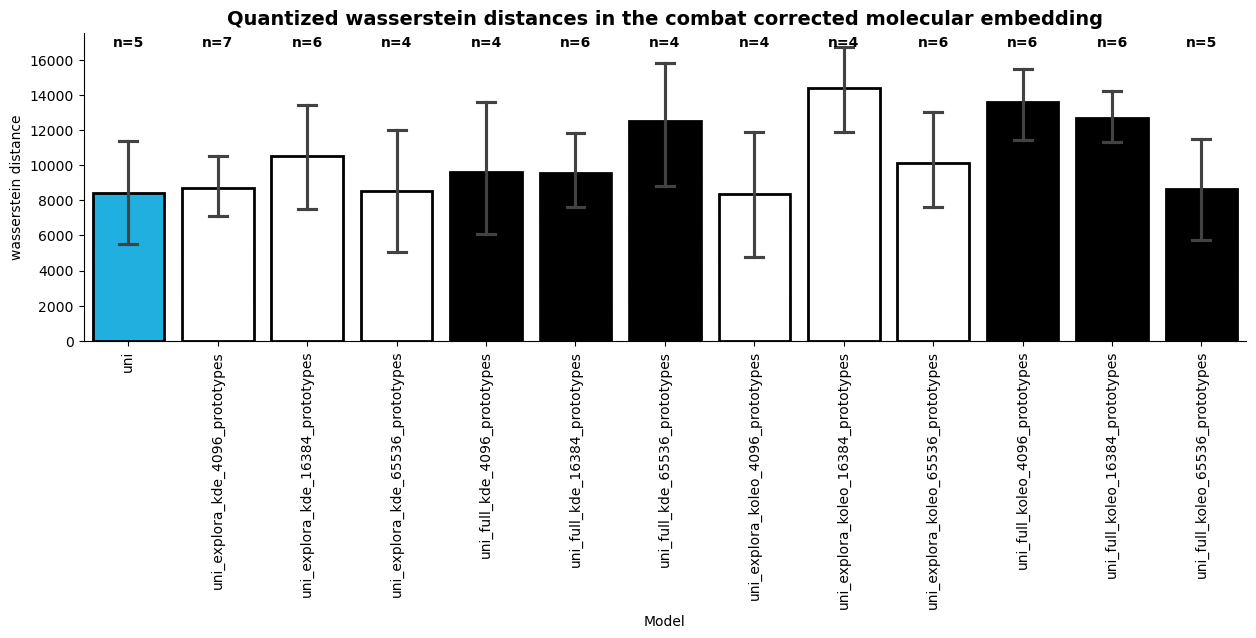

In [20]:
dfs = []
n_clusters = []

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

sorted_models = sort_retrained_models(config['retrained_model_list1'] + config['retrained_model_list2'])
for model_type in sorted_models:
    if model_type == "uni":
        df = df_sink_melted[df_sink_melted['model'] == "uni_explora"]
        df['model'] = "uni"
        n_clusters.append(df_summary.loc['uni_explora', 'n_clusters'])
    else:
        df = df_sink_melted[df_sink_melted['model'] == model_type]
        n_clusters.append(df_summary.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)


palette = []
for model in sorted_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', 
            y="wasserstein_distance", 
            palette=palette, 
            linewidth=2,
            edgecolor="black",
            capsize=0.2,
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"Quantized wasserstein distances in the combat corrected molecular embedding", weight="bold", fontsize=14)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=16600, s=f"n={n}", ha='center', va='bottom', weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure4/invasive_cancer_clustering_quantized_wasserstein_distances_molecular_combat_corrected_embedding_for_clusters_defined_with_best_silhouette_and_lower_ARI_patient.pdf"), bbox_inches="tight")